## Data Exploration

This right here is an optional notebook, but a crucial part of the data science/ML pipeline is understanding the data that you work with. It's important to know the different relationships in the data, what your downstream task is, and the different processing techniques available to you. 

For the purposes of this workshop, we're going to be working with the Perceptual Voice Qualities Database (PVQD). It's a dataset that has contains speakers enunciating two vowels /a/ and /i/, and then speaking a list of five sentences. Three clinicians then rate each sample across 6 perceptual qualities, of which 5 are given to you. This rating is done on a 1-100 scale. The ratings are provided in `audio_ml_workshop_2023/data/train_test_split/`, and the audio files are provided in `audio_ml_workshop_2023/data/audio_clips/`.

Before running any analysis, it's good to know what data you're working with. I provided the demographics and diagnosis info in the `demographics.csv` file. We'll start by exploring the metadata of the data, and then get into the actual audio data from there.

In [4]:
import os 
import sys
sys.path.append("../")

import numpy as np 
import pandas as pd 
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

# Load in Torch, we're not doing much with it here!
import torch
import torchaudio

It's always important to have a train-validation-test split. In my opinion, you should at the very least perform a train-test split **before conducting any analysis**. The test set should **never** be touched during training and analysis of data, and only used for evaluation at the end of a project. This way you have a set of held-out data that you know you haven't been overfitting to. 

In this workshop, I've provided a 80-10-10 train-val-test split for you. For this data exploration, we're just going to look at the training data. Let's load it in now! We'll load in the training data's perceptual qualities (in `y_train.csv`) and the demographics data.

In [3]:
# Load in the demographics data
demo_df = pd.read_csv("../data/pvqd/demographics.csv")

# Load in the training data's perceptual qualities labels
pq_train = pd.read_csv("../data/pvqd/train_test_split/y_train.csv")

If you were finding a dataset online, you might know the answers to these questions already if they were provided by the dataset's creators. But let's go ahead and start with the basics. You might not always know how much data is in the dataset

First question! What do the demographics of the dataset look like?

In [5]:
# Display the first 10 data points
demo_df.head(10)

,Participant ID,Gender,Age,Diagnosis
0,BL01,M,46,NaN
1,BL02,F,76,NaN
2,BL03,F,88,NaN
3,BL04,F,42,NaN
4,BL05,F,75,NaN
5,BL06,F,65,NaN
6,BL07,F,24,NaN
7,BL08,F,27,NaN
8,BL09,M,70,NaN
9,BL10,F,21,NaN


Already we see something interesting. We have the participant id, which, because we do speech research, I'm going to call the speaker_id from now on. We have their gender and age, and another column that lists diagnoses. We see that the first 10 entries are all NaN--weird. We'll get back to that later. How you deal with missing values is an **incredibly** important modeling choice. 

Let's see how much data we have first.

In [7]:
# Report the Length of the Data
total_participants = len(demo_df)
print("Total Number of Participants %s" % total_participants)

# TODO: Compute the number of participants in the training set
training_num = len(pq_train)
print("Training Set Size: %s" % training_num)


Total Number of Participants 297
Training Set Size: 235


So we have 297 participants. Starting to get a sense of our data, but we're still not really sure at all about things. Let's delve into the demographics data a bit more. The dataframe has three columns: age, gender, and diagnosis. Let's try grouping the data by gender and count who all is in the dataset.

In [9]:
# A group-by operation: Calculate aggregate statistics and other operations on data points with the same value for a column! 
# Let's count the number of men and women in the dataframe

demo_df.groupby("Gender").agg("count").reset_index()

,Gender,Participant ID,Age,Diagnosis
0,F,141,141,126
1,Female,13,13,13
2,M,82,82,77
3,Male,1,1,1
4,f,29,29,29
5,female,13,13,13
6,m,8,8,8
7,male,10,10,10


### Soooooo, that's not good at all!!! 

It turns out that the demographics csv isn't as clean as we might have hoped. We're going to have to **clean** the dataframe so we can get the analysis we want. 

**Arguably, data cleaning and collection is the most labor-intensive part of many ML pipelines.**

At least in my opinion, others in the lab might disagree!

### So what do we do?

First off, including participant id, age, and diagnosis in the count seems to be really messy. Firstly, if we're just counting values, why is the diagnosis column different than the age column?? (Hint: it's cause of those NaN's from before). That won't do. Let's just take the Participant ID and Gender columns.


In [22]:
demo_df[["Participant ID", "Gender"]]

KeyError: "['Participant ID'] not in index"

Hahahahahahahaha--you must be joking. What the *** does it mean that `['Participant ID'] not in index`??? It's right there in the headers. Let's print out the column names. 

In [11]:
print(demo_df.columns)

Index(['Participant ID ', 'Gender', 'Age', 'Diagnosis '], dtype='object')


Ok, so. Whoever made this csv (me) didnt strip the whitespace in the "Participant ID " column name, resulting in an error. 

Let's try including the whitespace and trying again.

In [14]:
demo_df[["Participant ID ", "Gender"]].head(3)

,Participant ID,Gender
0,BL01,M
1,BL02,F
2,BL03,F


Stupid. But ok, we got the subset of the dataframe we want to analyze. Now we have to fix that Gender column. 

Luckily for us, Pandas as a pretty nice way of dealing with strings. If you have a column that's a column of strings, Pandas let's you perform a variety of modfications and queries on those strings via the `.str.`. I've provided the code for fixing the Gender column below!

We'll also be using a handy function called `Series.map` that allows you to apply a dictionary or Series to a column in Pandas. We'll take advantage of this to fix the Gender column!

In [18]:
# Process the gender column, let's just make gender either a 'm' or 'f' value
lowered_gender = demo_df["Gender"].str.lower()

gender_dict = {
    "female": "f",
    "male": "m",
    'm': 'm',
    "f": 'f'
}

lowered_gender = lowered_gender.map(gender_dict)

demo_df["Gender"] = lowered_gender

Let's try selecting only two columns and performing the groupby like before!

In [21]:
demo_df[["Participant ID ", "Gender"]].groupby("Gender").agg("count").reset_index()

,Gender,Participant ID
0,f,196
1,m,101


It worked!! Now we know that the dataset is roughly split up into 2/3 women and 1/3 men. 

### What else can we do with demographics?

Well we still have the age and diagnoses column, let's try exploring those next.

For age, let's plot some histograms! There's a lot of numbers and the visualizations will make it easier.

<Axes: xlabel='Age', ylabel='Count'>

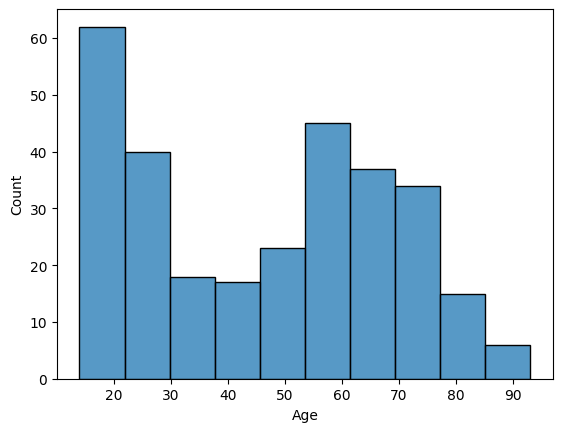

In [23]:
sns.histplot(data=demo_df, x="Age")

Let's explore out some other important distributional data for fun!

In [26]:
print("Mean Age %s " % demo_df["Age"].mean())
print("Median Age %s " % demo_df["Age"].median())

#TODO: Compute the Max and Min age
print("Max Age %s " % demo_df["Age"].max())
print("Min Age %s " % demo_df["Age"].min())

Mean Age 46.72727272727273 
Median Age 48.0 
Max Age 93 
Min Age 14 


Let's not just silo each demographic detail away from one another, let's look to see how the histogram and statistics change across gender!

<Axes: xlabel='Age', ylabel='Count'>

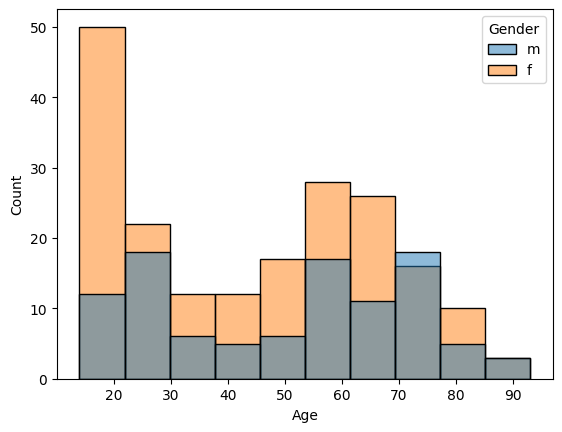

In [27]:
sns.histplot(data=demo_df, x="Age", hue="Gender")

In [35]:
# TODO: Modify the below code to calculate the min and the max as well!
demo_df[["Gender", "Age"]].groupby("Gender").agg(["mean", "median"]).reset_index()

Gender        Age       
               mean median
0      f  44.913265   46.0
1      m  50.247525   56.0

So that's interesting! 